# Example of SGD-UAP attack on a MobileNetV2 model trained on CIFAR-10

We used a pre-trained model borrowed from Huy Phan GitHub repository (https://github.com/huyvnphan/PyTorch_CIFAR10). Go to this repository to get the state dictionary of the pre-trained model used for this example. 

In [4]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataloaders import cifar10_loader
from utils import train_classifier as tr
import copy
from cifar10_models.mobilenetv2 import mobilenet_v2
import os
from pruning import UnstructuredPruning
from attacks import sgdUAP


# Define what device we are using
use_cuda=True
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda:1" if (use_cuda and torch.cuda.is_available()) else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA Available:  True


In [8]:
#Load pre-trained mobileNetV2 model 

model = mobilenet_v2(pretrained=True).to(device)
model.eval()

#Set training and test batch sizes 
batch_size_tr, batch_size_test = 64, 64

#Load training and test data
train_loader, test_loader = cifar10_loader.get_loader(batch_size_tr, batch_size_test)

accuracies = []

#Percentage of pruning to explore
perc = [0, 0.2, 0.4]
# Values of epsilon to explore
epsilon = [0, 4, 8, 16]

#Placeholder to store the accuracies
accuracies = torch.zeros((len(perc), len(epsilon)))

Files already downloaded and verified
Files already downloaded and verified


## Computing the clean accuracy

In [9]:
print("----------------------------------")
print("CLEAN ACCURACY")
print("----------------------------------")
print("PRUNING PERCENTAGE: 0%")
print("Accuracy after pruning: ")
acc_pruned = tr.get_accuracy(model, test_loader, device)
accuracies[0][0] = acc_pruned.cpu()
print(f'Test accuracy: {100 * acc_pruned:.3f}%')

for i in range(len(perc)):
    if perc[i] == 0: continue 
    model_pruned = copy.deepcopy(model).to(device)
    UnstructuredPruning.UnstructuredPruning(model_pruned, perc[i])
    print("PRUNING PERCENTAGE: ", 100*perc[i], "%")
    acc_pruned = tr.get_accuracy(model_pruned, test_loader, device)
    accuracies[i][0] = acc_pruned.cpu()
    print(f'Test accuracy: {100 * acc_pruned:.3f}%')
    

----------------------------------
CLEAN ACCURACY
----------------------------------
PRUNING PERCENTAGE: 0%
Accuracy after pruning: 
Test accuracy: 93.910%
PRUNING PERCENTAGE:  20.0 %
Test accuracy: 93.650%
PRUNING PERCENTAGE:  40.0 %
Test accuracy: 88.670%


## Computing the UAPs and the robust accuracy

----------------------------------
UAP Attack
----------------------------------
EPSILON:  0
EPSILON:  4
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


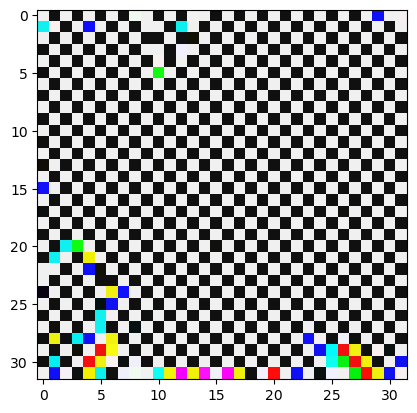

Non-pruned model - Test Accuracy = 34.970%
PRUNING PERCENTAGE:  20.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


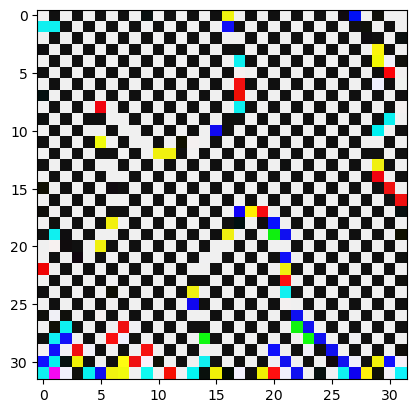

Test Accuracy = 45.450%
PRUNING PERCENTAGE:  40.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


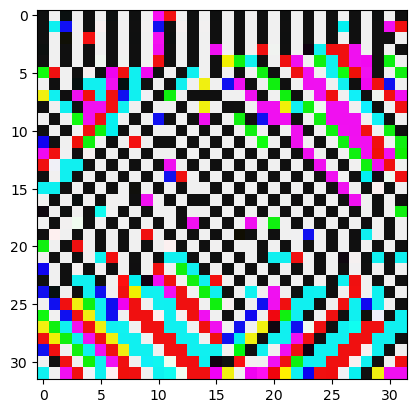

Test Accuracy = 43.650%
EPSILON:  8
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


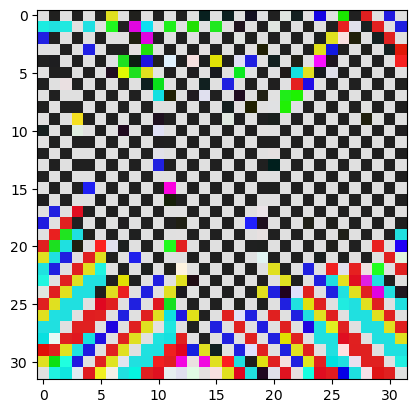

Non-pruned model - Test Accuracy = 19.500%
PRUNING PERCENTAGE:  20.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


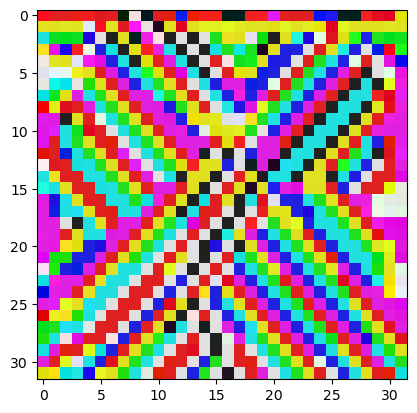

Test Accuracy = 21.080%
PRUNING PERCENTAGE:  40.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


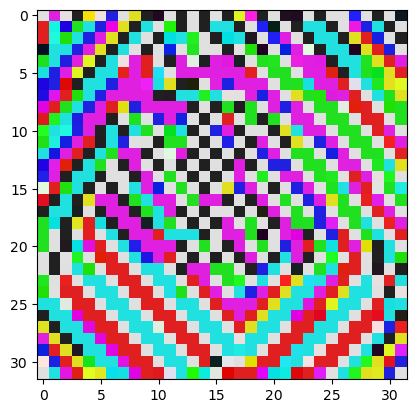

Test Accuracy = 11.880%
EPSILON:  16
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


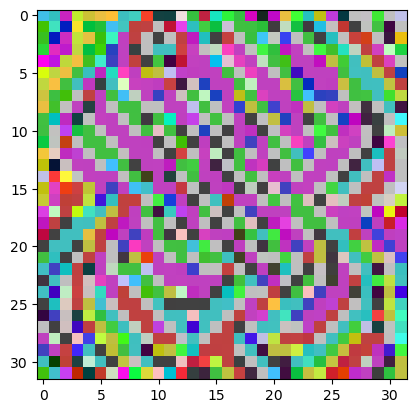

Non-pruned model - Test Accuracy = 10.140%
PRUNING PERCENTAGE:  20.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


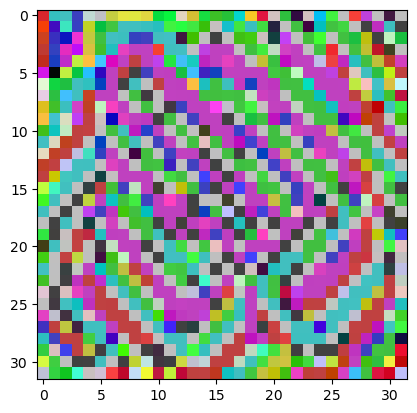

Test Accuracy = 10.220%
PRUNING PERCENTAGE:  40.0 %
INITIALIZATION NUMBER:  1
INITIALIZATION NUMBER:  2


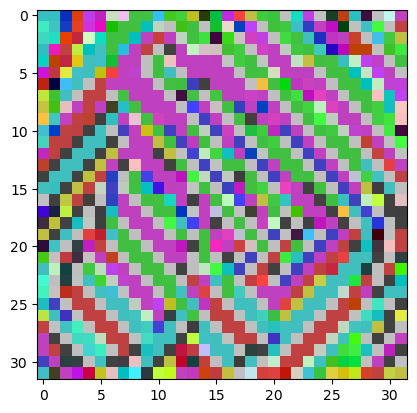

Test Accuracy = 10.020%


In [10]:
#Number of epochs for running the UAP attack
n_epochs = 20
#Adversarial loss used to optimize the UAPs
adv_loss = nn.CrossEntropyLoss(reduction = 'none')

print("----------------------------------")
print("UAP Attack")
print("----------------------------------")

# Run test for each epsilon
for i in range(len(epsilon)):
    print("EPSILON: ", epsilon[i])
    if epsilon[i] == 0: continue
    for j in range(len(perc)):
        if perc[j] == 0:
            acc, ex, perturbation = sgdUAP.test(model, device, test_loader, n_epochs, epsilon[i]/255.0, starts=2, beta=10, 
                                        loss_fn = adv_loss)
            plt.imshow(transforms.ToPILImage()(perturbation.to("cpu")))
            plt.show()
            accuracies[j][i] = acc
            print(f"Non-pruned model - Test Accuracy = {100*acc:.3f}%")
        else:
            model_pruned = copy.deepcopy(model).to(device)
            UnstructuredPruning.UnstructuredPruning(model_pruned, perc[j])
            print("PRUNING PERCENTAGE: ", 100*perc[j], "%")
            acc, ex, perturbation = sgdUAP.test(model_pruned, device, test_loader, n_epochs, epsilon[i]/255.0, starts=2, 
                                                beta=10, loss_fn = adv_loss)
            plt.imshow(transforms.ToPILImage()(perturbation.to("cpu")))
            plt.show()
            accuracies[j][i] = acc
            print(f"Test Accuracy = {100*acc:.3f}%")

## Plot the results

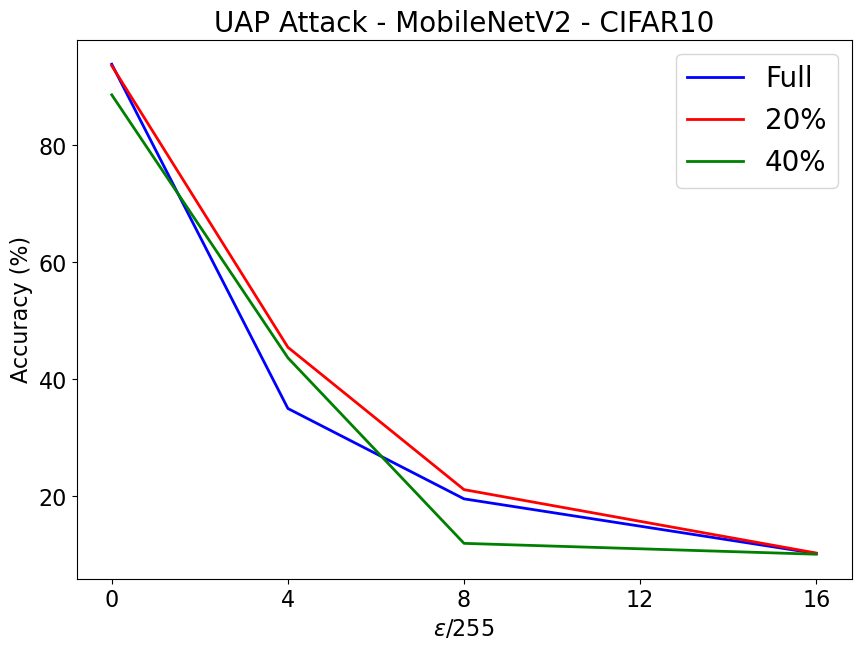

In [11]:
eps = np.array(epsilon)
accs = np.array(accuracies)*100
plt.figure(figsize=(10,7))
plt.plot(eps, accs[0,:],'b', linewidth=2)
plt.plot(eps, accs[1,:], 'r', linewidth=2)
plt.plot(eps, accs[2,:], 'g', linewidth=2)
plt.xlabel('$\epsilon$/255',fontsize=16)
plt.ylabel('Accuracy (%)',fontsize=16)
plt.legend(('Full', '20%', '40%'), fontsize=20)
plt.title('UAP Attack - MobileNetV2 - CIFAR10',fontsize=20)
plt.yticks(fontsize=16)
plt.xticks([0, 4, 8, 12, 16], fontsize=16)
plt.show()